# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 1000,
        'noise': 0.2,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)    
list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 243
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1], [0, 0, 0, 1, 2], [0, 0, 0, 2, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 2], [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 0, 2], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 2], [0, 0, 1, 2, 0], [0, 0, 1, 2, 1], [0, 0, 1, 2, 2], [0, 0, 2, 0, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 2], [0, 0, 2, 1, 0], [0, 0, 2, 1, 1], [0, 0, 2, 1, 2], [0, 0, 2, 2, 0], [0, 0, 2, 2, 1], [0, 0, 2, 2, 2], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 0, 2], [0, 1, 0, 1, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 2], [0, 1, 0, 2, 0], [0, 1, 0, 2, 1], [0, 1, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 2], [0, 1, 1, 1, 0], [0, 1, 1, 1, 1], [0, 1, 1, 1, 2], [0, 1, 1, 2, 0], [0, 1, 1, 2, 1], [0, 1, 1, 2, 2], [0, 1, 2, 0, 0], [0, 1, 2, 0, 1], [0, 1, 2, 0, 2], [0, 1, 2, 1, 0], [0, 1, 2, 1, 1], [0, 1, 2, 1, 2], [0, 1, 2, 2, 0], [0, 1, 2, 2, 1], [0, 1, 2, 2, 2], [0, 2, 0, 0, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 2], [0, 2, 0, 1, 

  0%|          | 0/243 [00:00<?, ?it/s]

List length: 21
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 0, 2, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 1, 1, 0, 0], [0, 2, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 1, 0], [1, 0, 1, 0, 0], [1, 1, 0, 0, 0], [2, 0, 0, 0, 0]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_110_drop0.25e500b256_custom/lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.2bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_1000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.2bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index, no_noise=False):
        
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
        print('interpretation_net_no_noise', path_identifier_lambda_net_data_loading)
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        print(path_identifier_lambda_net_data_loading)
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == True:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == True:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == True:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


interpretation_net_no_noise lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   51.7s finished


lnets_1000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.2bmin0.2bmax0.4lowd0.5azero0.25arand0.1


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    7.2s finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
521  1373158606         0.000        -0.378         0.000         0.000   
737  1373158606         0.093         0.907         0.000         0.000   
740  1373158606         0.000        -0.400         0.000         0.489   
660  1373158606        -0.381        -0.406         0.000         0.000   
411  1373158606         0.000         0.000         0.000         0.000   

     00011-target  00020-target  00100-target  00101-target  00110-target  \
521         0.000        -0.884         0.858         0.000         0.999   
737        -0.577         0.000         0.000         0.000         0.000   
740         0.492         0.000         0.000         0.000         0.000   
660         0.000         0.000         0.597         0.000         0.000   
411         0.618         0.000         0.000         0.000         0.000   

     00200-target  01000-target  01001-target  01010-target  01100-target  \
521         0.000         0.000         0.000         0.000         0.000   
737         0.000         0.000         0.000         0.000         0.000   
740         0.617         0.000         0.000         0.000         0.000   
660         0.000         0.000        -0.381         0.000         0.000   
411         0.654         0.000         0.000         0.000         0.072   

     02000-target  10000-target  10001-target  10010-target  10100-target  \
521         0.000         0.000         0.000         0.000         0.706   
737         0.000         0.000        -0.185         0.000         0.000   
740         0.000         0.609         0.000         0.000         0.000   
660         0.000         0.000         0.000         0.000         0.000   
411         0.000         0.000        -0.818         0.000         0.000   

     11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
521         0.000         0.000              -0.123              -0.299   
737         0.000        -0.947               0.134               0.857   
740         0.000         0.000              -0.173              -0.180   
660         0.000        -0.029              -0.278              -0.496   
411        -0.606         0.000              -0.027               0.105   

     00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
521              -0.007               0.007               0.005   
737               0.016              -0.082              -0.533   
740              -0.134               0.683               0.365   
660               0.045              -0.062               0.043   
411              -0.083               0.010               0.584   

     00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
521              -0.859               1.042              -0.037   
737               0.038              -0.041               0.018   
740              -0.126               0.403              -0.080   
660              -0.001               0.550              -0.020   
411              -0.013               0.159              -0.065   

     00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
521               0.981              -0.124               0.105   
737               0.014               0.011               0.029   
740              -0.087               0.372               0.128   
660               0.008               0.013              -0.122   
411              -0.036               0.552               0.023   

     01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
521              -0.009              -0.040              -0.026   
737               0.001               0.001               0.017   
740              -0.030              -0.011              -0.137   
660              -0.307               0.026               0.053   
411              -0.004               0.005               0.030   

     02000-lstsq_lambda  10000-lstsq_lambda  10001-lstsq_lambda  \
521              -0.050               0.1

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  00000-target  00001-target  00002-target  00010-target  \
count       1000.000      1000.000      1000.000      1000.000      1000.000   
mean  1373158606.000         0.011         0.011         0.005         0.006   
std            0.000         0.266         0.268         0.292         0.286   
min   1373158606.000        -1.000        -0.994        -0.997        -0.985   
25%   1373158606.000         0.000         0.000         0.000         0.000   
50%   1373158606.000         0.000         0.000         0.000         0.000   
75%   1373158606.000         0.000         0.000         0.000         0.000   
max   1373158606.000         0.989         0.992         0.996         0.994   

       00011-target  00020-target  00100-target  00101-target  00110-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean          0.002        -0.002         0.012        -0.006         0.013   
std           0.286         0.272         0.283         0.258         0.300   
min          -0.999        -0.983        -0.993        -0.970        -0.985   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.990         0.973         0.999         0.993         0.999   

       00200-target  01000-target  01001-target  01010-target  01100-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean          0.009         0.004         0.009        -0.001         0.004   
std           0.279         0.261         0.280         0.277         0.275   
min          -0.989        -0.989        -0.991        -0.982        -0.993   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.992         0.993         0.994         0.988         0.999   

       02000-target  10000-target  10001-target  10010-target  10100-target  \
count      1000.000      1000.000      1000.000      1000.000      1000.000   
mean         -0.003        -0.002         0.006        -0.027        -0.010   
std           0.291         0.266         0.281         0.301         0.270   
min          -0.999        -0.964        -0.992        -0.998        -0.981   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.998         1.000         0.994         0.998         0.985   

       11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
count      1000.000      1000.000            1000.000            1000.000   
mean         -0.008         0.013               0.000               0.020   
std           0.283         0.300               0.265               0.303   
min          -0.995        -0.999              -1.074              -1.266   
25%           0.000         0.000              -0.087              -0.076   
50%           0.000         0.000              -0.004               0.010   
75%           0.000         0.000               0.069               0.105   
max           0.976         0.988               1.111               1.225   

       00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
count            1000.000            1000.000            1000.000   
mean               -0.015               0.029               0.007   
std                 0.255               0.328               0.264   
min                -0.936              -1.213              -0.986   
25%                -0.070              -0.084              -0.031   
50%                -0.017               0.010      

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[9.41681430e-02, 3.72841132e-01, 6.39588164e-01, 4.31336366e-01,
        8.56509560e-01],
       [7.96713547e-01, 3.73376287e-01, 2.66019144e-01, 5.03038595e-01,
        7.23443984e-01],
       [5.71495801e-01, 2.77435866e-01, 8.10306934e-01, 4.42926452e-01,
        6.03366085e-01],
       [1.95610034e-01, 7.27693240e-01, 1.76130307e-01, 6.94681505e-01,
        9.26936666e-01],
       [7.98376944e-01, 8.60156528e-01, 2.02660185e-01, 4.99962330e-01,
        8.25956287e-01],
       [8.89907347e-01, 6.92556560e-01, 4.23117334e-01, 3.95357490e-01,
        4.34007680e-01],
       [7.99697868e-02, 1.41172526e-01, 2.86208851e-01, 7.98252916e-01,
        1.44731288e-01],
       [8.06024056e-02, 8.76677670e-01, 1.23288125e-01, 5.51061324e-01,
        8.09642353e-01],
       [9.47447594e-01, 3.43203002e-01, 6.69193460e-01, 4.65364961e-01,
        8.87984698e-01],
       [7.66968762e-01, 7.97805359e-01, 3.51139847e-01, 1.41215150e-04,
        6.35638876e-01]])

In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[ 0.31245439],
       [-0.15222278],
       [ 0.87404965],
       [-0.54879067],
       [-0.13124573],
       [ 0.60260322],
       [ 0.10198129],
       [-0.26288474],
       [ 0.8455101 ],
       [ 0.38247315]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset = lambda_net_dataset_without_noise

            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(10000, 240)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 240)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 240)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
6252  1373158606         0.000         0.000         0.000         0.000   
4684  1373158606         0.215         0.000         0.000         0.000   
1731  1373158606         0.000         0.000         0.480         0.479   
4742  1373158606         0.000         0.000         0.133         0.000   
4521  1373158606         0.000         0.003         0.000         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
6252         0.000         0.000         0.000         0.135         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000         0.000         0.000         0.000   
4742         0.905        -0.360         0.000         0.000         0.000   
4521        -0.949         0.000         0.000         0.000         0.000   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
6252         0.278         0.000        -0.016         0.000         0.000   
4684         0.276         0.000         0.000         0.000        -0.446   
1731         0.000         0.000         0.000         0.000        -0.350   
4742         0.089         0.000         0.000         0.000         0.000   
4521         0.000        -0.281         0.000         0.000         0.000   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
6252         0.000         0.000         0.000         0.000         0.705   
4684        -0.313        -0.867         0.000         0.000         0.000   
1731         0.793         0.000         0.000         0.000        -0.642   
4742         0.000         0.000         0.000         0.000         0.000   
4521         0.000         0.000         0.000        -0.529         0.000   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
6252         0.838         0.000              -0.029               0.015   
4684         0.000         0.000               0.210               0.009   
1731         0.000         0.000               0.006               0.030   
4742         0.000        -0.173              -0.035               0.060   
4521         0.000        -0.378               0.020              -0.009   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
6252              -0.011               0.019               0.005   
4684              -0.006              -0.014              -0.003   
1731               0.448               0.465               0.000   
4742               0.103               0.034               0.861   
4521               0.002              -0.041              -0.899   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
6252              -0.016               0.045               0.125   
4684               0.009               0.010              -0.001   
1731              -0.008               0.003              -0.004   
4742              -0.369               0.032               0.005   
4521               0.010              -0.027              -0.004   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
6252              -0.003               0.258               0.024   
4684               0.004               0.257               0.007   
1731               0.013              -0.020               0.054   
4742              -0.014               0.063               0.027   
4521               0.000               0.018              -0.281   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
6252              -0.022              -0.006              -0.002   
4684               0.003               0.005              -0.426   
1731               0.005               0.012              -0.380   
4742              -0.005               0.000              -0.009   
4521              -0.010               0.005               0.009   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
123  1373158606        -0.101         0.000         0.000         0.000   
274  1373158606         0.000         0.000         0.000         0.000   
600  1373158606        -0.445         0.000        -0.058         0.000   
519  1373158606        -0.375         0.000         0.000         0.000   
225  1373158606        -1.000         0.000         0.000         0.000   

     00011-target  00020-target  00100-target  00101-target  00110-target  \
123         0.000         0.000         0.000         0.000         0.608   
274        -0.124         0.000         0.000         0.000         0.000   
600         0.000         0.000         0.000         0.000         0.732   
519         0.000         0.000         0.000         0.000        -0.171   
225         0.000        -0.759         0.000         0.000         0.000   

     00200-target  01000-target  01001-target  01010-target  01100-target  \
123         0.000         0.040         0.000         0.000         0.000   
274        -0.650         0.000         0.475        -0.494         0.000   
600         0.000         0.000         0.000         0.000         0.000   
519         0.000         0.000         0.000         0.303        -0.595   
225        -0.139         0.000         0.025         0.000         0.000   

     02000-target  10000-target  10001-target  10010-target  10100-target  \
123        -0.007         0.000         0.000         0.000         0.000   
274         0.000         0.000         0.000         0.000         0.000   
600         0.000         0.000         0.000        -0.729         0.000   
519         0.000         0.000         0.000         0.000         0.000   
225         0.000         0.000         0.000         0.000         0.000   

     11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
123         0.497         0.000              -0.155               0.063   
274         0.000        -0.944               0.095               0.044   
600         0.261         0.000              -0.465              -0.009   
519         0.000        -0.450              -0.197              -0.054   
225        -0.535         0.000              -0.730              -0.074   

     00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
123              -0.016               0.059              -0.042   
274              -0.052              -0.083              -0.090   
600              -0.041              -0.019              -0.049   
519              -0.050               0.008               0.017   
225              -0.147              -0.558               0.168   

     00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
123              -0.031               0.054              -0.009   
274               0.010              -0.179              -0.011   
600               0.009               0.159               0.016   
519              -0.038              -0.296               0.076   
225              -0.368              -0.166               0.122   

     00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
123               0.562              -0.009               0.094   
274               0.018              -0.537              -0.020   
600               0.681              -0.123               0.113   
519              -0.115               0.115              -0.106   
225               0.070              -0.118              -0.131   

     01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
123              -0.024               0.003              -0.021   
274               0.408              -0.442               0.048   
600              -0.023              -0.011              -0.053   
519               0.013               0.265              -0.504   
225               0.043              -0.036               0.066   

     02000-lstsq_lambda  10000-lstsq_lambda  10001-lstsq_lambda  \
123              -0.024               0.0

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
666  1373158606         0.000         0.000         0.000         0.000   
129  1373158606         0.000         0.000         0.000         0.000   
784  1373158606         0.000         0.000         0.000         0.000   
152  1373158606         0.000         0.000         0.000         0.000   
920  1373158606        -0.047         0.000         0.000         0.000   

     00011-target  00020-target  00100-target  00101-target  00110-target  \
666        -0.845         0.000         0.000         0.000         0.000   
129         0.000         0.000         0.000         0.000         0.000   
784         0.459         0.000         0.000         0.135         0.000   
152         0.000         0.000         0.000         0.000         0.000   
920        -0.551         0.000         0.000         0.000         0.000   

     00200-target  01000-target  01001-target  01010-target  01100-target  \
666         0.000         0.000         0.000         0.000         0.000   
129         0.000         0.000         0.797         0.000         0.000   
784        -0.244         0.000         0.000        -0.836         0.000   
152         0.000         0.000         0.718         0.354         0.000   
920         0.000         0.000         0.000         0.000         0.000   

     02000-target  10000-target  10001-target  10010-target  10100-target  \
666         0.000         0.000         0.304        -0.026         0.000   
129         0.000         0.000        -0.394        -0.869         0.000   
784         0.000         0.000        -0.255         0.000         0.000   
152         0.000         0.497        -0.122         0.000        -0.679   
920         0.377         0.942         0.000         0.000         0.000   

     11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
666         0.833        -0.223              -0.036              -0.002   
129        -0.507        -0.032               0.054              -0.015   
784         0.000         0.000               0.094              -0.056   
152         0.000         0.000              -0.046               0.064   
920         0.000         0.692              -0.158               0.032   

     00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
666               0.008               0.006              -0.831   
129              -0.029              -0.065               0.066   
784              -0.007              -0.034               0.496   
152              -0.027               0.182              -0.036   
920              -0.091               0.039              -0.443   

     00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
666              -0.012               0.027               0.019   
129              -0.001               0.003              -0.037   
784              -0.012              -0.099               0.156   
152              -0.106              -0.079               0.035   
920               0.003              -0.008               0.048   

     00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
666              -0.006              -0.036               0.058   
129              -0.049               0.021               0.060   
784              -0.012              -0.188              -0.106   
152              -0.016               0.005               0.150   
920               0.000              -0.002               0.370   

     01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
666              -0.028               0.024               0.027   
129               0.809              -0.004               0.013   
784               0.029              -0.778               0.044   
152               0.638               0.270               0.032   
920               0.048              -0.140              -0.020   

     02000-lstsq_lambda  10000-lstsq_lambda  10001-lstsq_lambda  \
666              -0.028               0.0

## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
[<function inet_coefficient_loss_wrapper.<locals>.inet_coefficient_loss at 0x7f9d889cbdc0>, <function inet_lambda_fv_loss_wrapper.<locals>.inet_lambda_fv_loss at 0x7f9d889cbf70>, <function inet_coefficient_loss_wrapper.<locals>.inet_coefficient_loss at 0x7f9db0b13040>, <function inet_lambda_fv_loss_wrapper.<locals>.inet_lambda_fv_loss at 0x7f9db0b130d0>]
Epoch 1/500
40/40 [==============================] - 16s 258ms/step - loss: 0.3937 - r2_inet_coefficient_loss: 0.4118 - r2_inet_lambda_fv_loss: 2.3689 - mae_inet_coefficient_loss: 0.2439 - mae_inet_lambda_fv_loss: 0.3936 - val_loss: 0.2651 - val_r2_inet_coefficient_loss: 0.4923 - val_r2_inet_lambda_fv_loss: 0.2560 - val_mae_inet_coefficient_loss: 0.2661 - val_mae_inet_lambda_fv_loss: 0.2651
Epoch 2/500
40/40 [==============================] - 7s 183ms/step - loss: 0.2717 - r2_inet_coefficient_loss: 0.4964 - r2_ine

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:  4.0min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

Symbolic Regression Optimization Time: 0:18:35
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True
True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.5s finished


per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:16
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_symbolic_regression_functions
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_target_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_symbolic_regression_functions
inet_polyn

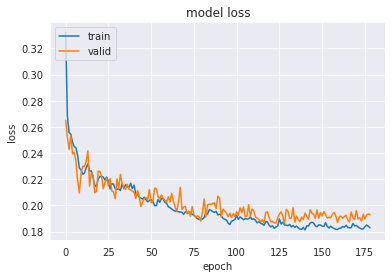

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
interpretation_net_output_shape

110

In [25]:
(interpretation_net_output_monomials+1)*sparsity

126

In [26]:
history_list[-1]['loss'][-1]

0.18283340334892273

In [27]:
history_list[-1]['val_loss'][-1]

0.1928786039352417

In [28]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials', 'symbolic_regression_functions'])

In [29]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [30]:
poly_optimize

<tf.Tensor: shape=(110,), dtype=float32, numpy=
array([0.0000000e+00, 1.0000000e+00, 2.0000000e+00, 3.0000000e+00,
       4.0000000e+00, 1.3028977e-09, 3.5416432e-09, 9.6271835e-09,
       2.6169397e-08, 7.1135801e-08, 1.9336716e-07, 5.2562643e-07,
       1.4288008e-06, 3.8838834e-06, 1.0557489e-05, 2.8698232e-05,
       7.8009878e-05, 2.1205284e-04, 5.7641941e-04, 1.5668704e-03,
       4.2591952e-03, 1.1577693e-02, 3.1471431e-02, 8.5548222e-02,
       2.3254418e-01, 6.3212061e-01, 1.3028977e-09, 3.5416432e-09,
       9.6271835e-09, 2.6169397e-08, 7.1135801e-08, 1.9336716e-07,
       5.2562643e-07, 1.4288008e-06, 3.8838834e-06, 1.0557489e-05,
       2.8698232e-05, 7.8009878e-05, 2.1205284e-04, 5.7641941e-04,
       1.5668704e-03, 4.2591952e-03, 1.1577693e-02, 3.1471431e-02,
       8.5548222e-02, 2.3254418e-01, 6.3212061e-01, 1.3028977e-09,
       3.5416432e-09, 9.6271835e-09, 2.6169397e-08, 7.1135801e-08,
       1.9336716e-07, 5.2562643e-07, 1.4288008e-06, 3.8838834e-06,
       1.05574

In [31]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [32]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          90624       input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [33]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [34]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.060 0.099  4.300   
target_polynomials_VS_lstsq_target_polynomials     0.020 0.029  1.603   
target_polynomials_VS_inet_polynomials             0.275 0.374 19.562   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.060 0.098  1.838   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.268 0.367 12.743   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.277 0.376 27.393   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.614   
target_polynomials_VS_lstsq_target_polynomials         0.893   
target_polynomials_VS_inet_polynomials                 0.148   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.612   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.156   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.152   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.010   
target_polynomials_VS_lstsq_target_polynomials                    0.300   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...                  NaN   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   
lstsq_target_polynomials_VS_symbolic_regression...                  NaN   
inet_polynomials_VS_symbolic_regression_functions                   NaN   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.023    0.029    0.343   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.017    0.022    0.285   
lambda_preds_VS_lstsq_target_polynomials             0.022    0.029    0.343   
lambda_preds_VS_inet_polynomials                     0.183    0.226    2.108   
lambda_preds_VS_symbolic_regression_functions        0.116    0.148    2.303   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.015    0.020    0.180   
target_polynomials_VS_lstsq_target_polynomials       0.006    0.008    0.104   
target_polynomials

In [35]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.017 0.026 0.017 0.020   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.017 0.023 0.015 0.018   
lambda_preds_VS_lstsq_target_polynomials           0.017 0.024 0.017 0.021   
lambda_preds_VS_inet_polynomials                   0.178 0.157 0.095 0.138   
lambda_preds_VS_symbolic_regression_functions      0.125 0.110 0.102 0.116   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.008 0.014 0.008 0.014   
target_polynomials_VS_lstsq_target_polynomials     0.002 0.005 0.002 0.003   
target_polynomials_VS_inet_polynomials             0.177 0.152 0.094 0.138   
target_polynomials_VS_symbolic_regression_funct... 0.124 0.106 0.103 0.114   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.008 0.012 0.008 0.014   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.177 0.153 0.093 0.138   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.124 0.109 0.101 0.115   
lstsq_target_polynomials_VS_inet_polynomials       0.178 0.152 0.093 0.137   
lstsq_target_polynomials_VS_symbolic_regression... 0.124 0.106 0.103 0.114   
inet_polynomials_VS_symbolic_regression_functions  0.142 0.149 0.048 0.162   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.032 0.020 0.020 0.009   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.017 0.018 0.016 0.009   
lambda_preds_VS_lstsq_target_polynomials           0.032 0.021 0.020 0.009   
lambda_preds_VS_inet_polynomials                   0.106 0.244 0.141 0.088   
lambda_preds_VS_symbolic_regression_functions      0.134 0.176 0.140 0.074   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.028 0.013 0.014 0.005   
target_polynomials_VS_lstsq_target_polynomials     0.009 0.005 0.005 0.001   
target_polynomials_VS_inet_polynomials             0.104 0.245 0.141 0.089   
target_polynomials_VS_symbolic_regression_funct... 0.131 0.178 0.137 0.075   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.028 0.014 0.013 0.005   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.102 0.242 0.141 0.087   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.131 0.174 0.140 0.072   
lstsq_target_polynomials_VS_inet_polynomials       0.103 0.245 0.141 0.089   
lstsq_target_polynomials_VS_symbolic_regression... 0.132 0.177 0.137 0.074   
inet_polynomials_VS_symbolic_regression_functions  0.107 0.263 0.140 0.043   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.032 0.015 0.017 0.030   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.025 0.014 0.016 0.020   
lambda_preds_VS_lstsq_target_polynomials           0.031 0.014 0.017 0.026   
lambda_preds_VS_inet_polynomials                   0.287 0.155 0.110 0.177   
lambda_preds_VS_symbolic_regression_functions      0.114 0.146 0.117 0.119   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.021 0.008 0.005 0.021   
target_polynomials_VS_lstsq_target_polynomials     0.008 0.004 0.005 0.013   
target_polynomials_VS_inet_polynomials             0.283 0.157 0.110 0.171   
target_polynomials_VS_symbolic_regression_funct... 0.109 0.147 0.114 0.110   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.021 0.007 0.007 0.017   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.283 0.154 0.107 0.174   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.109 0.144 0.114 0.119   
lstsq_target_polynomials_VS_inet_polynomials       0.286 0.156 0.110 0.173   
lstsq_target_polynomials_VS_symbolic_regression... 0.110 0.145 0.115 0.114   
inet_polynomials_VS_symbolic_regression_functions  0.229 0.109 0.148 0.192   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.024 0.018 0.021 0.027   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.016 0.016 0.020 0.019   
lambda_preds_VS_lstsq_target_polynomials           0.023 0.018 0.020 0.0

In [36]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2    L-3  \
lambda_preds_VS_target_polynomials                  0.991 0.990 0.985  0.986   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.992 0.992 0.989  0.989   
lambda_preds_VS_lstsq_target_polynomials            0.992 0.991 0.986  0.986   
lambda_preds_VS_inet_polynomials                    0.102 0.656 0.533  0.400   
lambda_preds_VS_symbolic_regression_functions       0.465 0.773 0.479  0.529   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.998 0.997 0.996  0.994   
target_polynomials_VS_lstsq_target_polynomials      1.000 1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials              0.095 0.649 0.531  0.398   
target_polynomials_VS_symbolic_regression_funct...  0.460 0.777 0.464  0.543   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.998 0.998 0.996  0.993   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.100 0.656 0.537  0.385   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...  0.459 0.777 0.477  0.534   
lstsq_target_polynomials_VS_inet_polynomials        0.096 0.648 0.533  0.406   
lstsq_target_polynomials_VS_symbolic_regression...  0.464 0.778 0.468  0.546   
inet_polynomials_VS_symbolic_regression_functions  -5.096 0.078 0.822 -0.513   

                                                     L-4    L-5    L-6    L-7  \
lambda_preds_VS_target_polynomials                 0.993  0.995  0.989  0.983   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998  0.997  0.993  0.986   
lambda_preds_VS_lstsq_target_polynomials           0.993  0.995  0.990  0.983   
lambda_preds_VS_inet_polynomials                   0.928  0.280  0.550 -0.448   
lambda_preds_VS_symbolic_regression_functions      0.885  0.669  0.524 -0.044   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.995  0.998  0.995  0.996   
target_polynomials_VS_lstsq_target_polynomials     0.999  1.000  1.000  1.000   
target_polynomials_VS_inet_polynomials             0.929  0.265  0.549 -0.417   
target_polynomials_VS_symbolic_regression_funct... 0.885  0.661  0.531 -0.040   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.995  0.998  0.996  0.996   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.931  0.278  0.554 -0.444   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.887  0.675  0.523 -0.045   
lstsq_target_polynomials_VS_inet_polynomials       0.929  0.264  0.548 -0.430   
lstsq_target_polynomials_VS_symbolic_regression... 0.884  0.664  0.533 -0.043   
inet_polynomials_VS_symbolic_regression_functions  0.926 -4.146 -0.750 -0.466   

                                                      L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                  0.988 0.994 0.996 0.981   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.993 0.995 0.996 0.991   
lambda_preds_VS_lstsq_target_polynomials            0.988 0.995 0.995 0.985   
lambda_preds_VS_inet_polynomials                    0.165 0.406 0.824 0.348   
lambda_preds_VS_symbolic_regression_functions       0.846 0.468 0.805 0.707   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.995 0.998 1.000 0.991   
target_polynomials_VS_lstsq_target_polynomials      0.999 1.000 1.000 0.996   
target_polynomials_VS_inet_polynomials              0.171 0.396 0.821 0.378   
target_polynomials_VS_symbolic_regression_funct...  0.844 0.461 0.809 0.749   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.995 0.999 0.999 0.994   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.168 0.404 0.826 0.355   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...  0.846 0.471 0.808 0.712   
lstsq_target_polynomials_VS_inet_polynomials        0.159 0.400 0.821 0.375   
lstsq_target_polynomials_VS_symbolic_regression...  0.841 0.464 0.811 0.738   
inet_polynomials_VS_symbolic_regression_functions  -1.645 0.075 0.431 0.618   

                                                     L-12   L-13   L-14  L-15  \
lambda_preds_VS_target_polynomials                  0.988  0.995  0.992 0.980   
lambda_preds_VS_lstsq_lambda_pred_polynomials    

In [37]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9400139396434513


0.0568615729883229*a**2 - 0.0897069523926384*a*b - 0.0058191015751726*a*c + 0.0280633424087345*a*d + 0.039865121334065*a*e + 0.143873461960141*a - 0.0403516076080059*b**2 + 0.035430201123116*b*c + 0.0004292702663563*b*d + 0.0252716183979818*b*e + 0.0052419640918686*b - 0.0084022043095468*c**2 + 0.0071363349495788*c*d + 0.0754250807117944*c*e - 0.0249323104681374*c + 0.0051997846201003*d**2 + 0.04822137155655*d*e - 0.0380001491652369*d - 0.0751002083531446*e**2 - 0.0328679468325265*e - 0.672184312927079

In [38]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.06978656684011976 (100 Samples)
Mean (only positive): 0.5439646281914627 (82 Samples)


In [39]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9933938094013537 (100 Samples)
Mean (only positive): 0.9933938094013537 (100 Samples)


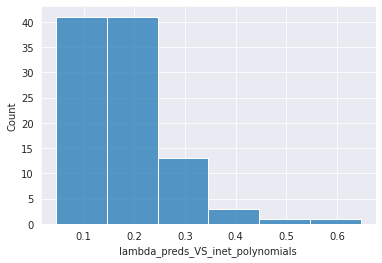

In [40]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

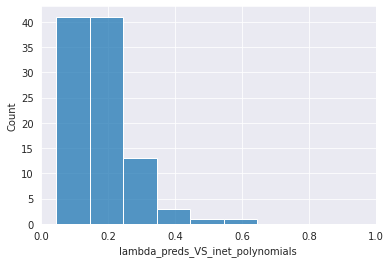

In [41]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


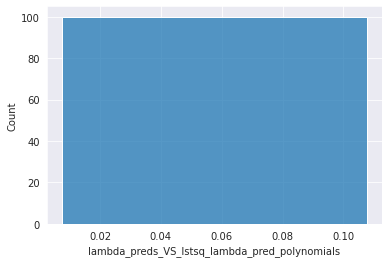

In [42]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

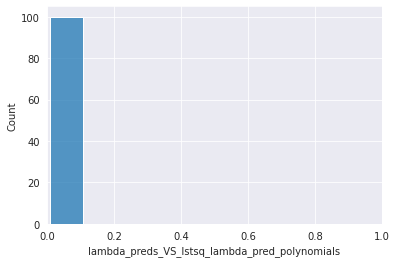

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


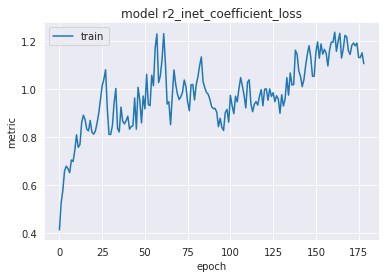

In [44]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


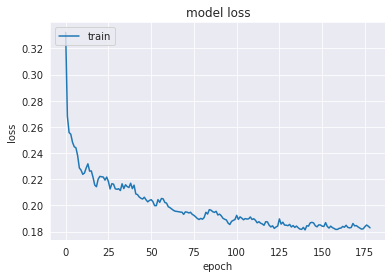

In [45]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [46]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [47]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [48]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [49]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


-0.2684*a**2 + 0.0038*a*b + 0.0411*a*c + 0.0429*a*d + 0.0287*a*e - 0.1553*a + 0.0045*b**2 - 0.3649*b*c + 0.0109*b*d + 0.0196*b*e - 0.0415*b + 0.0075*c**2 + 0.008*c*d + 0.0346*c*e - 0.0713*c - 0.9368*d**2 + 0.7984*d*e + 1.0113*d - 0.1541*e**2 + 0.152*e + 0.0268

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


-0.354*a**2 - 0.0041*a*b - 0.0161*a*c - 0.0005*a*d - 0.0001*a*e + 0.0026*a - 0.0361*b**2 - 0.3995*b*c + 0.0039*b*d - 0.0065*b*e + 0.0364*b - 0.0225*c**2 + 0.0047*c*d - 0.0325*c*e + 0.043*c - 0.9321*d**2 + 0.8666*d*e + 0.9933*d - 0.0217*e**2 + 0.0525*e - 0.0298

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


-0.3618*a**2 - 0.4053*b*c - 0.9211*d**2 + 0.8881*d*e + 0.9753*d

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.216199994087219*a + 0.0707999989390373*b*d - 0.0696000009775162*b + 0.144299998879433*d + 0.382299989461899*e

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


X3*X4

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


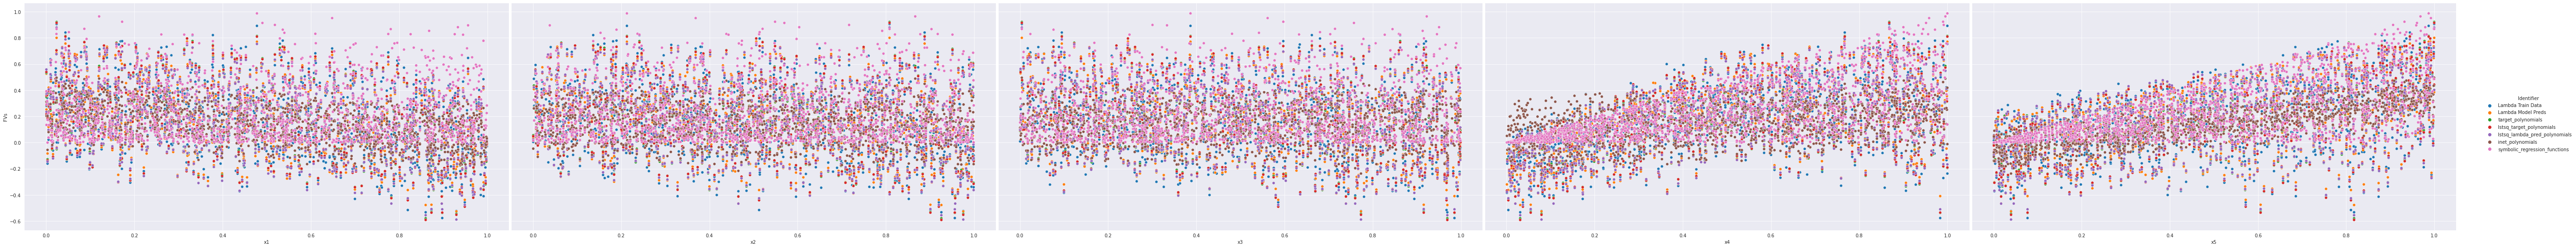

In [50]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

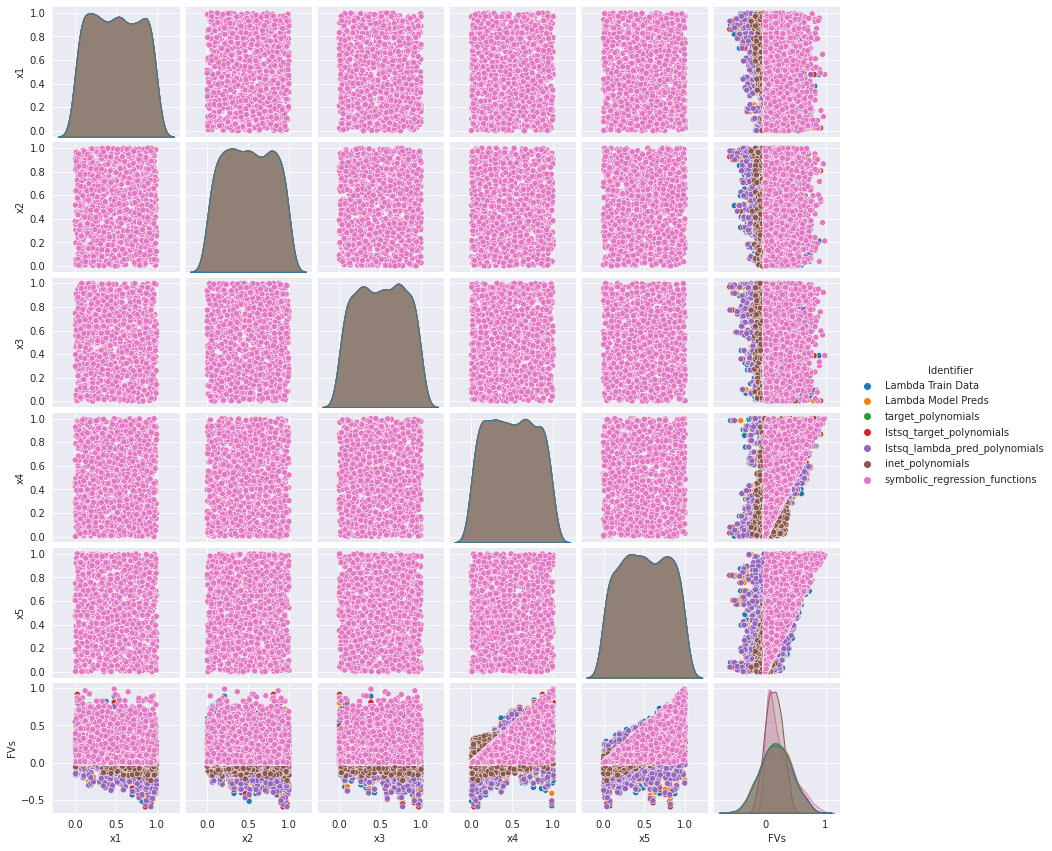

In [51]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

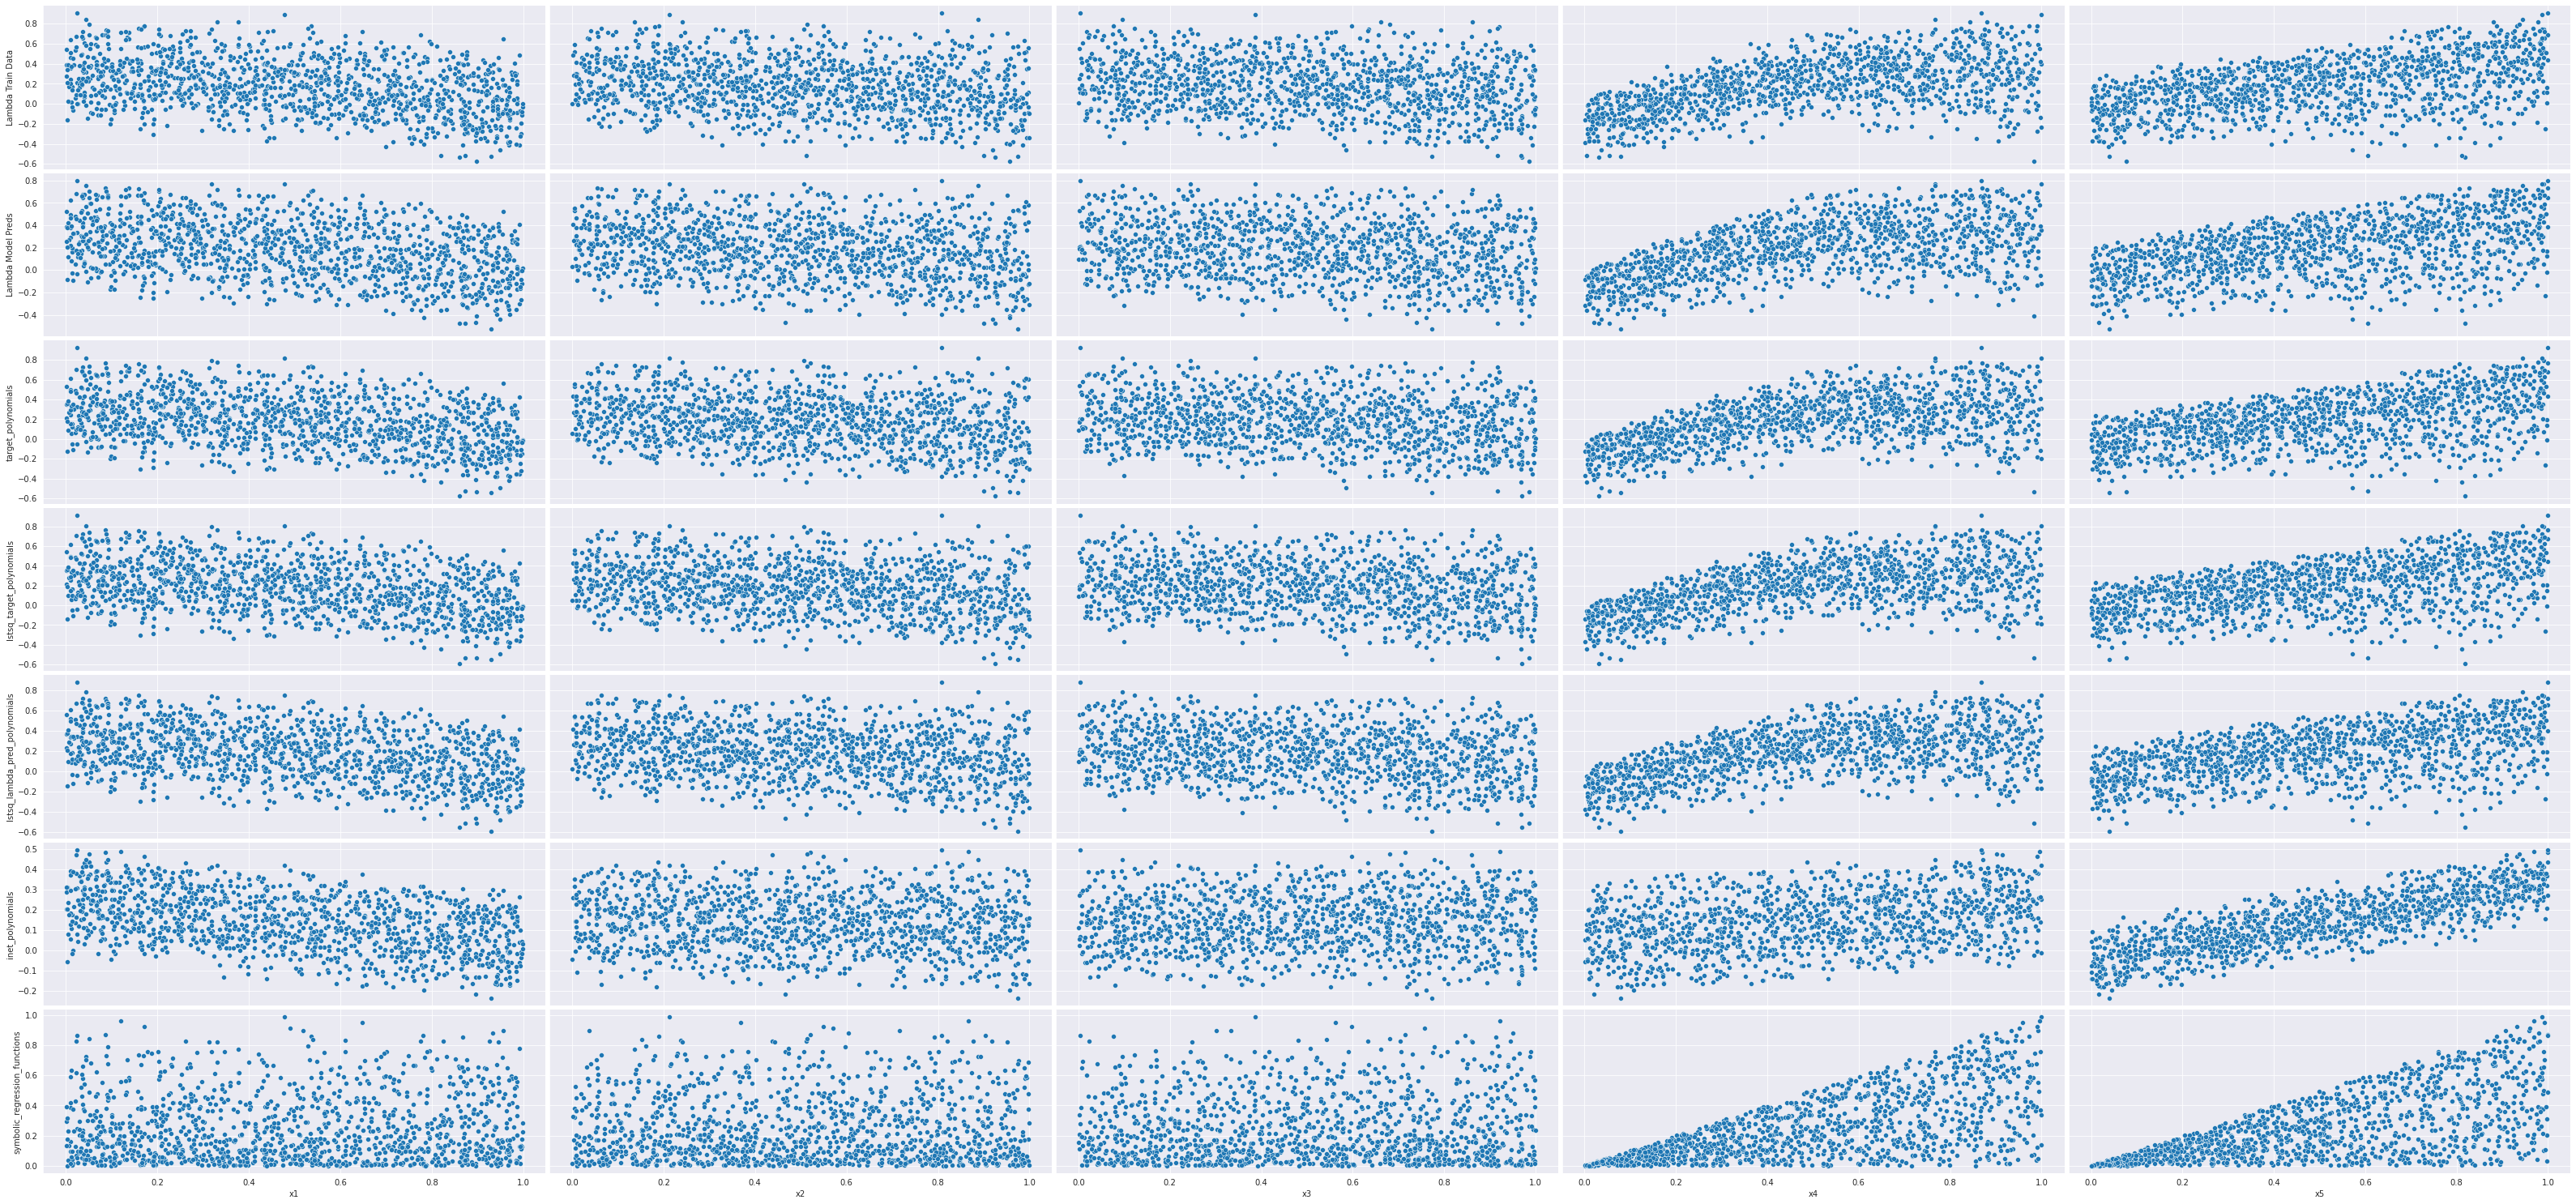

In [52]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [53]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [54]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

True
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [55]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.9969


In [56]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 10.0055


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [57]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [58]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.4747


In [59]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [60]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.15323923528194427 
 Curr_res: 0.17893710732460022 
 Iteration 1, Step 16
Optimization terminated at 0.0968203917145729


array([-0.35465467, -0.41193652, -0.01766815, -0.06353537,  0.94261307,
        0.18209696,  0.63791955,  0.27701473,  0.04227114,  0.84219384,
        0.90637195,  0.222556  ,  0.9198462 ,  0.68789077,  0.42705178,
        0.878158  ,  0.6943959 ,  0.46567595,  0.52925766,  0.33019018,
        0.12754858,  0.16153514,  0.5085137 ,  0.44301772,  0.35205877,
        0.8969147 ,  0.24940813,  0.76328313,  0.85935795,  0.08480155,
        0.20418596,  0.28848922,  0.65142167,  0.7106751 ,  0.8695041 ,
        0.23745108,  0.6688912 ,  0.7115667 ,  0.21899498,  0.7702793 ,
        0.45055628,  0.95493364,  0.71695936,  0.98945487,  0.1511141 ,
        0.06240606,  0.15209746,  0.99522185,  0.7830266 ,  0.10455871,
        0.40613055,  0.04687667,  0.83119476,  0.8572043 ,  0.28471017,
        0.2854122 ,  0.3370154 ,  0.6854944 ,  0.46100128,  0.6476023 ,
        0.65136576,  0.3152976 ,  0.10924482,  0.05294752,  0.05602324,
        0.11310673,  0.26957738,  0.50644445,  0.72646904,  0.43

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [61]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

Displacement  Cylinders  Model Year   USA  Acceleration
0         0.618      1.000       0.000 1.000         0.238
1         0.729      1.000       0.000 1.000         0.208
2         0.646      1.000       0.000 1.000         0.179
3         0.610      1.000       0.000 1.000         0.238
4         0.605      1.000       0.000 1.000         0.149

In [62]:
#%load_ext autoreload

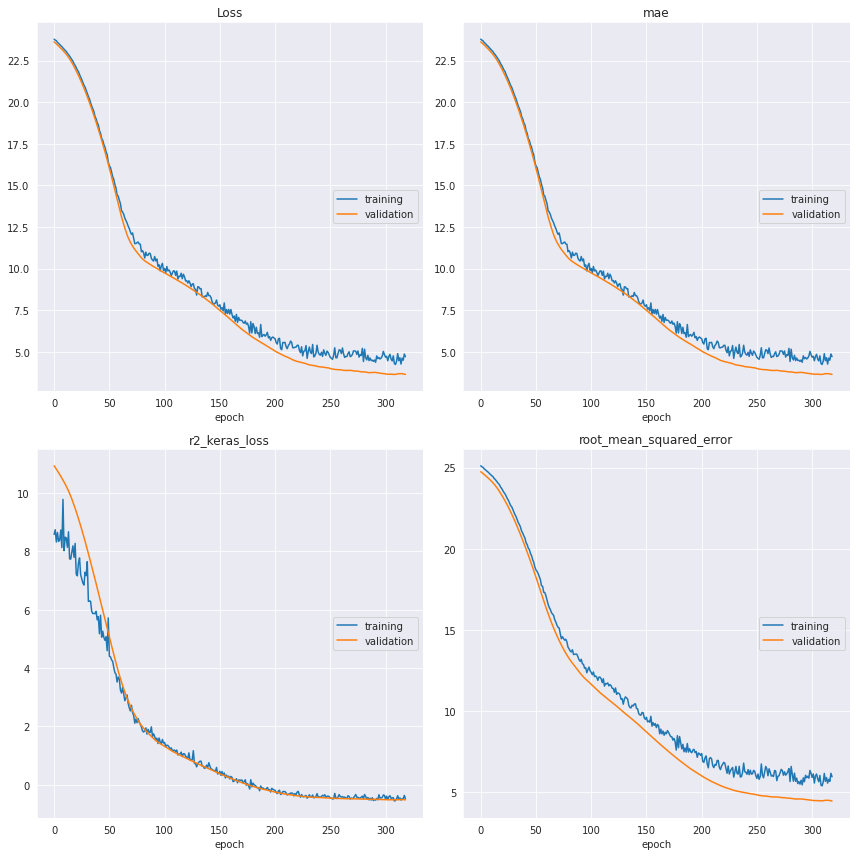

Loss
	training         	 (min:    4.240, max:   23.789, cur:    4.709)
	validation       	 (min:    3.642, max:   23.629, cur:    3.643)
mae
	training         	 (min:    4.240, max:   23.789, cur:    4.709)
	validation       	 (min:    3.642, max:   23.629, cur:    3.643)
r2_keras_loss
	training         	 (min:   -0.557, max:    9.781, cur:   -0.477)
	validation       	 (min:   -0.517, max:   10.934, cur:   -0.516)
root_mean_squared_error
	training         	 (min:    5.384, max:   25.116, cur:    5.947)
	validation       	 (min:    4.450, max:   24.751, cur:    4.450)


In [63]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [64]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [65]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [66]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()